In [1]:
# imports
from astropy.io import fits
import matplotlib.pyplot as plt
# import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read AGN Lists From CSV

In [3]:
# read from a given csv file and return a list of its contents 
def ReadFile(filename) : 
    # initialize list
    file = []

    # open csv file
    with open(path_csv+filename, newline='') as csv_file : 
        reader = csv.reader(csv_file, delimiter=',', quotechar='"')
        # output file into list for easy access
        for row in reader :
            file.append(row)

    # print column names 
    print(filename, '\tcolumns: ', file[0])

    # return an array of type int with column names clipped off
    return( np.array(file[1:], dtype=int) )


In [4]:
# read AGN ID and index from csv files
agn_irSel20 = ReadFile('\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv')
agn_xrSel20 = ReadFile('\Match_Chandra2016_XrayAGN_to_COSMOS2020.csv')

# transpose arrays to get columns
agn_irSel20_id, agn_irSel20_i = agn_irSel20.T
agn_xrSel20_id, agn_xrSel20_i = agn_xrSel20.T

\Match_COSMOS2020_IRAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']
\Match_Chandra2016_XrayAGN_to_COSMOS2020.csv 	columns:  ['ID', 'i']


In [5]:
# print info
print('Number of IR AGN in COSMOS 2020:\t',    len(agn_irSel20_id))
print('Number of Xray AGN in COSMOS 2020:\t',  len(agn_xrSel20_id))

Number of IR AGN in COSMOS 2020:	 1533
Number of Xray AGN in COSMOS 2020:	 2176


In [6]:
# # test: left and right must match
# print(agn_irSel20[0][0], '==', agn_irSel20_id[0])
# print(agn_irSel20[0][1], '==', agn_irSel20_i[0])
# print(agn_xrSel20[0][0], '==', agn_xrSel20_id[0])
# print(agn_xrSel20[0][1], '==', agn_xrSel20_i[0])

# Get Data From Catalogs

In [7]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
cols20 = inf20[1].columns
inf20.close()

In [8]:
# get IRAC data (unit = 'uJy')
ch1_data  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('Ch1 read')
ch2_data  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('Ch2 read')
ch3_data  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('Ch3 read')
ch4_data  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('Ch4 read')
# get ID
id20_data = np.array(data20['ID_COSMOS2015'])
print('id read')

Ch1 read
Ch2 read
Ch3 read
Ch4 read
id read


In [9]:
# open COSMOS 2016 catalog file and get data 
inf16 = fits.open(path_cat+'\chandra_COSMOS_legacy_opt_NIR_counterparts_20160113_4d.fits')
data16 = inf16[1].data
cols16 = inf16[1].columns
inf16.close()

In [10]:
# get data arrays from columns
id16_data = np.array(data16['id_k_uv'])
print('id read')
L0510_data = np.array(data16['Lx_0510']) # x-ray luminosity in the 0.5-10 KeV band
print('L0510 read')
k0510_data = np.array(data16['abs_corr_0510'])  # absorbtion correction coefficient in the 0.5-10 KeV band
print('abs_corr_0510 read')

id read
L0510 read
abs_corr_0510 read


# Isolate Data By Selection Method

In [11]:
# match agn ids
key_ir, key_xr = match.match(agn_irSel20_id, agn_xrSel20_id)

# initialize
mask_ir = np.ones(agn_irSel20_id.size, dtype=bool)
mask_xr = np.ones(agn_xrSel20_id.size, dtype=bool)

# set matched index to false
mask_ir[key_ir] = False
mask_xr[key_xr] = False

# remove xray selected agn from ir selected list
agn_irSel20_id_ONLY = agn_irSel20_id[mask_ir]
agn_irSel20_i_ONLY  = agn_irSel20_i[mask_ir]

# remove ir selected agn from xray selected list 
agn_xrSel20_id_ONLY = agn_xrSel20_id[mask_xr]
agn_xrSel20_i_ONLY  = agn_xrSel20_i[mask_xr]

# create list of ir/xray match
agn20_id_BOTH = agn_irSel20_id[key_ir]
agn20_i_BOTH  = agn_irSel20_i[key_ir]

In [12]:
# print info 
print('Number of IR only:\t',   len(agn_irSel20_i_ONLY))
print('Number of Xray only:\t', len(agn_xrSel20_i_ONLY))
print('Number of matches:\t',   len(agn20_i_BOTH))

Number of IR only:	 886
Number of Xray only:	 1529
Number of matches:	 647


In [13]:
# returns the IRAC channels only at indeces i 
def SelectIRAC(i, applyMask=True, printInfo=True):
    # get data
    a = ch1_data[i]
    b = ch2_data[i]
    c = ch3_data[i]
    d = ch4_data[i]

    if(applyMask == True) :
        # mask bad values 
        mask = (a > 0) & (b > 0) & (c > 0) & (d > 0)
        # apply mask 
        a = a[mask]
        b = b[mask]
        c = c[mask]
        d = d[mask] 

    if(printInfo == True) : 
        # print info
        print('Col \t Min \t\t Max \t\t Count')
        print('-------------------------------------------------------------')
        print('CH1 \t', min(a), '\t', max(a), '\t', len(a))
        print('CH2 \t', min(b), '\t', max(b), '\t', len(b))
        print('CH3 \t', min(c), '\t', max(c), '\t', len(c))
        print('CH4 \t', min(d), '\t', max(d), '\t', len(d))
        print('-------------------------------------------------------------')
    
    # return data 
    return a,b,c,d

In [14]:
# filter data by selection method
ch1_ir, ch2_ir, ch3_ir, ch4_ir = SelectIRAC(agn_irSel20_i_ONLY, True, False)
ch1_xr, ch2_xr, ch3_xr, ch4_xr = SelectIRAC(agn_xrSel20_i_ONLY, True, False)
ch1_ix, ch2_ix, ch3_ix, ch4_ix = SelectIRAC(agn20_i_BOTH, True, False)

# Plot IRAC Colors With Exclusive Selection Lists

In [15]:
# calculate colors for ir 
x_ir = np.log10( ch3_ir / ch1_ir ) # x = log10 ( f_5.6um / f_3.6um )
y_ir = np.log10( ch4_ir / ch2_ir ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for xray 
x_xr = np.log10( ch3_xr / ch1_xr ) # x = log10 ( f_5.6um / f_3.6um )
y_xr = np.log10( ch4_xr / ch2_xr ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for matched ir/xray
x_ix = np.log10( ch3_ix / ch1_ix ) # x = log10 ( f_5.6um / f_3.6um )
y_ix = np.log10( ch4_ix / ch2_ix ) # y = log10 ( f_8.0um / f_4.5 um )

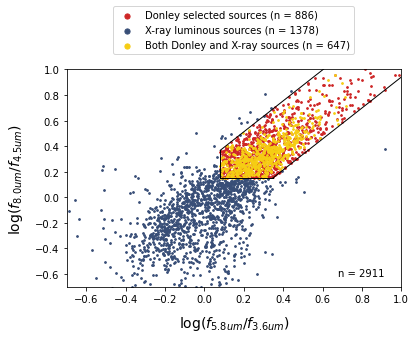

Number of IR only:	 886
Number of Xray only:	 1378
Number of matches:	 647
Total Number:		 2911
68.04938271604938 % of Xray sources fall outside wedge.
57.79517286366601 % of IR souces have no Xray greater than 10^43


In [16]:
# set standard plot format
myP.SetStyle()

# plot data
plt.scatter(x_ir, y_ir, marker='o', c=myP.c_ir,       s=3, label='Donley selected sources (n = '+str(len(x_ir))+')')
plt.scatter(x_xr, y_xr, marker='o', c=myP.c_xray,     s=3, label='X-ray luminous sources (n = '+str(len(x_xr))+')')
plt.scatter(x_ix, y_ix, marker='o', c=myP.c_ir_xray,  s=3, label='Both Donley and X-ray sources (n = '+str(len(x_ix))+')')

# plotting class
myP.PlotDonleyWedge()
myP.addtext_n(len(x_ir)+len(x_xr)+len(x_ix))

# customize
plt.legend(markerscale=3, bbox_to_anchor=(0.50, 1.18), loc='center')
# plt.title('IR and X-ray selected AGN from COSMOS sources') 

# set axis size and save
plt.axis([-1.5,2.5,-1.5,2.5]) 
myP.save(path_fig+'\COSMOS_IR-Xray_selection_FULL.png')
plt.axis([-0.7,1.0,-0.7,1.0]) 
myP.save(path_fig+'\COSMOS_IR-Xray_selection_ZOOM.png')

# display
plt.show()

# print info 
print('Number of IR only:\t',   len(x_ir))
print('Number of Xray only:\t', len(x_xr))
print('Number of matches:\t',   len(x_ix))
print('Total Number:\t\t',      len(x_ir)+len(x_xr)+len(x_ix))

print( len(x_xr) / (len(x_xr)+len(x_ix)) * 100., '% of Xray sources fall outside wedge.')
print( len(x_ir) / (len(x_ir)+len(x_ix)) * 100. ,'% of IR souces have no Xray greater than 10^43')

# Match Xray Data to IRAC Datapoints

In [17]:
## Build full agn lists:
##      agn_full_ids
##      agn_full_i20

# merge agn lists into one
agn_full_ids = np.unique(np.concatenate((agn_irSel20_id,agn_xrSel20_id)))

# match full agn list against COSMOS 2020 to get i
key_full20, agn_full_i20 = match.match(agn_full_ids, id20_data)


In [18]:
## Build xray matched agn lists:
##      agn_yX_ids
##      agn_yX_i16
##      agn_yX_i20

# match full agn list against Chandra 2016 to get id and i for xray data 
key_full16, agn_yX_i16 = match.match(agn_full_ids, id16_data)

# get list of agn with xray matches 
agn_yX_ids = agn_full_ids[key_full16]

# match xray data agn against COSMOS 2020 to get i for xray list 
key_yxid, agn_yX_i20 = match.match(agn_yX_ids, id20_data)

In [19]:
## Build no-xray matched agn lists:
##      agn_nX_ids
##      agn_nX_i20

# match agn with xray against the full list to get index matches
key_yx, key_full = match.match(agn_yX_ids, agn_full_ids)

# create mask that is false for any xray matches 
mask_nX = np.ones(agn_full_ids.size, dtype=bool)
mask_nX[key_full] = False

# apply mask to get lists with no xray data 
agn_nX_ids = agn_full_ids[mask_nX]
agn_nX_i20 = agn_full_i20[mask_nX]

In [20]:
# print information 
print('Number of total AGN:\t\t\t',         len(agn_full_ids))
print('Number of AGN with Xray data:\t\t',  len(agn_yX_ids))
print('Number of AGN without Xray data:\t', len(agn_nX_ids))
# print('(Note that values may be -99)')

Number of total AGN:			 3062
Number of AGN with Xray data:		 2263
Number of AGN without Xray data:	 799


In [21]:
# get xray data
L0510_agn = L0510_data[agn_yX_i16]
k0510_agn = k0510_data[agn_yX_i16]
Lx = L0510_agn - np.log10(k0510_agn) # k_abs = L_abs / L_int --> log(L_int) = log(L_abs) - log(k_abs)

# get masks for (in)valid data 
mask_goodX = Lx > 0 
mask_badX = ~ mask_goodX

# apply mask for valid data
agn_yX_ids_Xmasked = agn_yX_ids[mask_goodX]
agn_yX_i16_Xmasked = agn_yX_i16[mask_goodX]
agn_yX_i20_Xmasked = agn_yX_i20[mask_goodX]
Lx_Xmasked         = Lx[mask_goodX]

# apply invalid mask to get the removed ids/i20 
kicked_ids = agn_yX_ids[mask_badX]
kicked_i20 = agn_yX_i20[mask_badX]
print('Kicked from yX:', len(kicked_ids))

# add the removed yX ids/i20s to nX arrays
agn_nX_ids_Xmasked = np.concatenate((agn_nX_ids, kicked_ids))
agn_nX_i20_Xmasked = np.concatenate((agn_nX_i20, kicked_i20))


Kicked from yX: 66


C:\Users\polar\AppData\Local\Temp\ipykernel_3964\1411070485.py:4: RuntimeWarning: invalid value encountered in log10
  Lx = L0510_agn - np.log10(k0510_agn) # k_abs = L_abs / L_int --> log(L_int) = log(L_abs) - log(k_abs)


In [22]:
# print information 
print('Number of total AGN:\t\t\t',         len(agn_full_ids))
print('Number of AGN with Xray data:\t\t',  len(agn_yX_ids_Xmasked))
print('Number of AGN without Xray data:\t', len(agn_nX_ids_Xmasked))

Number of total AGN:			 3062
Number of AGN with Xray data:		 2197
Number of AGN without Xray data:	 865


In [23]:
# Get unmasked IRAC data
ch1_yX, ch2_yX, ch3_yX, ch4_yX = SelectIRAC(agn_yX_i20_Xmasked, False, True) 
ch1_nX, ch2_nX, ch3_nX, ch4_nX = SelectIRAC(agn_nX_i20_Xmasked, False, True) 

Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 -99.9 	 2890.8818 	 2197
CH2 	 -99.9 	 2585.7314 	 2197
CH3 	 -99.9 	 4258.4307 	 2197
CH4 	 -99.9 	 6295.71 	 2197
-------------------------------------------------------------
Col 	 Min 		 Max 		 Count
-------------------------------------------------------------
CH1 	 0.06996247 	 557.9681 	 865
CH2 	 0.027118225 	 1051.9921 	 865
CH3 	 0.3748381 	 2789.9287 	 865
CH4 	 0.37653038 	 5239.906 	 865
-------------------------------------------------------------


In [24]:
# mask for valid IRAC data 
mask_goodI = (ch1_yX > 0) & (ch2_yX > 0) & (ch3_yX > 0) & (ch4_yX > 0)

# apply mask to yX channels
ch1_yX_good = ch1_yX[mask_goodI]
ch2_yX_good = ch2_yX[mask_goodI]
ch3_yX_good = ch3_yX[mask_goodI]
ch4_yX_good = ch4_yX[mask_goodI]

# apply mask to Xray data
Lx_IXmasked = Lx_Xmasked[mask_goodI]

# apply mask to yX lists
agn_yX_ids_IXmasked = agn_yX_ids_Xmasked[mask_goodI]
agn_yX_i16_IXmasked = agn_yX_i16_Xmasked[mask_goodI]
agn_yX_i20_IXmasked = agn_yX_i20_Xmasked[mask_goodI]

# Plot IRAC Colors With Xray Color Bar

In [25]:
# calculate colors for with Xray
x_yX = np.log10( ch3_yX_good / ch1_yX_good ) # x = log10 ( f_5.6um / f_3.6um )
y_yX = np.log10( ch4_yX_good / ch2_yX_good ) # y = log10 ( f_8.0um / f_4.5 um )

# calculate colors for without Xray
x_nX = np.log10( ch3_nX / ch1_nX ) # x = log10 ( f_5.6um / f_3.6um )
y_nX = np.log10( ch4_nX / ch2_nX ) # y = log10 ( f_8.0um / f_4.5 um )

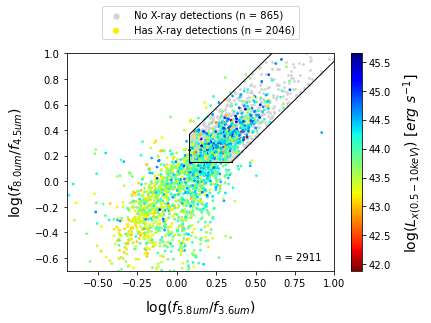

Number with Xray:	 2046
Number without Xray:	 865
Total Number:		 2911


In [26]:
# plot data16
plt.scatter(x_nX, y_nX, marker='o', s=3, c='lightgrey',                 label='No X-ray detections (n = '+str(len(x_nX))+')')
plt.scatter(x_yX, y_yX, marker='o', s=3, c=Lx_IXmasked, cmap='jet_r',   label='Has X-ray detections (n = '+str(len(x_yX))+')')

# color bar 
plt.colorbar(label='$\log(L_{x(0.5-10keV)}) \,\, [erg \,\, s^{-1}]$')

# plotting
myP.PlotDonleyWedge()
myP.addtext_n(len(x_nX)+len(x_yX))

# customize
# plt.title('IR and X-ray selected AGN from COSMOS sources')
plt.legend(markerscale=3, bbox_to_anchor=(0.50, 1.14), loc='center') 

# set axis size and save
plt.axis([-1.5,2.5,-1.5,2.5]) 
myP.save(path_fig+'\COSMOS_IR-Xray_XrayColorBar_FULL.png')
plt.axis([-0.7,1.0,-0.7,1.0]) 
myP.save(path_fig+'\COSMOS_IR-Xray_XrayColorBar_ZOOM.png')

# display
plt.show()

# print information 
print('Number with Xray:\t',    len(x_yX))
print('Number without Xray:\t', len(x_nX))
print('Total Number:\t\t',      len(x_yX)+len(x_nX))

# Plot Histogram of Xray Luminosity

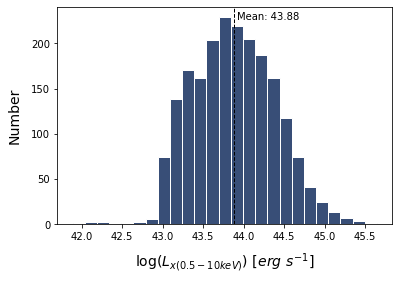

In [27]:
# Plot histogram.
n, bins, patches = plt.hist(Lx_IXmasked, 25, edgecolor='w', color=myP.c_xray)

# # scale values to interval [0,1] and apply colormap
# bin_centers = 0.5 * (bins[:-1] + bins[1:])
# col = bin_centers - min(bin_centers)
# col /= max(col)
# cm = plt.cm.get_cmap('jet_r')
# for c, p in zip(col, patches):
#     plt.setp(p, 'facecolor', cm(c))

# mean
mean = np.array(Lx_IXmasked).mean()
min_ylim, max_ylim = plt.ylim()
plt.axvline(mean, color='k', linestyle='dashed')
plt.text(mean*1.001, max_ylim*0.94, 'Mean: {:.2f}'.format(mean))

# set titles
# plt.title('X-ray luminosity histogram of IR and X-ray selected AGN')
plt.xlabel('$\log(L_{x(0.5-10keV)}) \,\, [erg \,\, s^{-1}]$')
plt.ylabel('Number')

# save
plt.savefig(path_fig+'\COSMOS_IR-Xray_XrayHist.png',bbox_inches ="tight",pad_inches=0.2,facecolor='w',edgecolor='w')

# display
plt.show()

In [28]:
# get mask of sources inside Donley Wedeg
mask_inWedge = myP.SourcesInDonleyWedge(x_yX, y_yX)

# apply mask to separate Lx
Lx_IXmasked_inWedge  = Lx_IXmasked[mask_inWedge]
Lx_IXmasked_outWedge = Lx_IXmasked[~mask_inWedge]

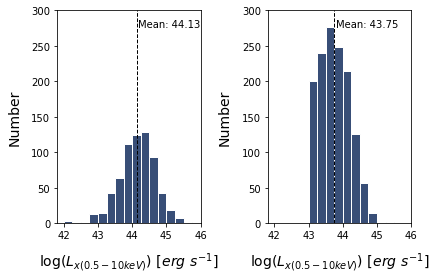

Number of sources inside wedge: 668
Number of sources outside wedge: 1378
Range inside wedge:	 41.887 45.646275
Range outside wedge:	 43.000263 45.4326


In [29]:
# subplots 
fig, (inWedge, outWedge) = plt.subplots(1,2)

## inWedge subplot

# plot all redshift histogram
inWedge.hist(Lx_IXmasked_inWedge, bins=np.arange(42,46,0.25), edgecolor='w', color=myP.c_xray)
inWedge.set_ylim(ymin=0, ymax=300)

# axis and titles 
# inWedge.set_title('X-ray luminosity of \nsources inside wedge')
inWedge.set_xlabel('$\log(L_{x(0.5-10keV)}) \,\, [erg \,\, s^{-1}]$')
inWedge.set_ylabel('Number')
inWedge.set_xticks([42,43,44,45,46])

# mean 
mean_all = Lx_IXmasked_inWedge.mean()
min_ylim_all, max_ylim_all = inWedge.get_ylim()
inWedge.axvline(mean_all, color='k',linestyle='dashed')
inWedge.text(mean_all*1.001, max_ylim_all*0.92, 'Mean: {:.2f}'.format(mean_all))

## outWedge subplot

# plot agn redshift histogram
outWedge.hist(Lx_IXmasked_outWedge, bins=np.arange(42,46,0.25), edgecolor='w', color=myP.c_xray)

# axis and titles 
# outWedge.set_title('X-ray luminosity of \nsources outside wedge')
outWedge.set_xlabel('$\log(L_{x(0.5-10keV)}) \,\, [erg \,\, s^{-1}]$')
outWedge.set_ylabel('Number')
outWedge.set_ylim(ymin=0, ymax=300)
outWedge.set_xticks([42,43,44,45,46])

# mean 
mean_agn = Lx_IXmasked_outWedge.mean()
min_ylim_agn, max_ylim_agn = outWedge.get_ylim()
outWedge.axvline(mean_agn, color='k',linestyle='dashed')
outWedge.text(mean_agn*1.001, max_ylim_agn*0.92, 'Mean: {:.2f}'.format(mean_agn))

## end subplots 

# formatting and save  
plt.tight_layout()
plt.savefig(path_fig+'\COSMOS_IR-Xray_XrayHist_split.png',bbox_inches ="tight",pad_inches=0.2,facecolor='w',edgecolor='w')
plt.show()

# print info 
print('Number of sources inside wedge:', len(Lx_IXmasked_inWedge))
print('Number of sources outside wedge:', len(Lx_IXmasked_outWedge))

print('Range inside wedge:\t',  min(Lx_IXmasked_inWedge),  max(Lx_IXmasked_inWedge))
print('Range outside wedge:\t', min(Lx_IXmasked_outWedge), max(Lx_IXmasked_outWedge))